In [10]:
using ITensors
using ITensorTDVP
using Plots
using Observers
using LinearAlgebra
using Statistics
using ProgressBars   
using DSP

In [90]:
function enrich_generic3(ϕ, ψ⃗; cutoff=1e-15, kwargs...)

"""
  Given spec from the eigen function, to extract its information use the 
  following functions:

  eigs(spec) returns the spectrum
  truncerror(spec) returns the truncation error
"""  
  Nₘₚₛ = length(ψ⃗) ##number of MPS

  @assert all(ψᵢ -> length(ψ⃗[1]) == length(ψᵢ), ψ⃗) ##check that all MPS inputs are of the same length

  N = length(ψ⃗[1]) 

  ψ⃗ = copy.(ψ⃗)
    
  ###Isn't this already a vector of MPS's?  
  ψ⃗ = convert.(MPS, ψ⃗)

  s = siteinds(ψ⃗[1])

  ##makes the orthogonality centre for each MPS to be at site N  
  ψ⃗ = orthogonalize.(ψ⃗, N)
  ϕ = orthogonalize!(ϕ, N)
  
  ##storage MPS
  phi = deepcopy(ϕ)
  
  ρϕ = prime(ϕ[N], s[N]) * dag(ϕ[N])
  ρ⃗ₙ = [prime(ψᵢ[N], s[N]) * dag(ψᵢ[N]) for ψᵢ in ψ⃗]
  ρₙ = sum(ρ⃗ₙ)
 
  """
  Is this needed?
  """
  ρₙ /=tr(ρₙ)

#   # Maximum theoretical link dimensions
 
  Cϕprev = ϕ[N]
  C⃗ₙ = last.(ψ⃗)
  
 
  for n in reverse(2:N)
     """
    In the paper they propose to do this step with no truncation. At the very
    least this cutoff should be a function parameter.
    """    
    
    left_inds = linkind(ϕ,n-1)
   
         #Diagonalize primary state ψ's density matrix    
    U,S,Vϕ,spec = svd(Cϕprev,left_inds; 
      lefttags = tags(linkind(ϕ, n - 1)),
      righttags = tags(linkind(ϕ, n - 1)))   

    x = dim(inds(S)[1])
    @assert(x == dim(linkind(ϕ, n - 1)))
    r = uniqueinds(Vϕ, S) # Indices of density matrix
    lϕ = commonind(S, Vϕ) # Inner link index from density matrix diagonalization
        

    # Compute the theoretical maximum bond dimension that the enriched state cannot exceeded: 
    abs_maxdim = bipart_maxdim(s,n - 1) - dim(lϕ)        
    # Compute the number of eigenvectors of ɸ's projected density matrix to retain:
    Kry_linkdim_vec = [dim(linkind(ψᵢ, n - 1)) for ψᵢ in ψ⃗]
        
   
    ω_maxdim = min(sum(Kry_linkdim_vec),abs_maxdim)
    
    if ω_maxdim !== 0


        # Construct identity matrix
        ID = 1
        rdim = 1
        for iv in r
          IDv = ITensor(dag(iv)', iv);
          rdim *= dim(iv)
          for i in 1:dim(iv)
            IDv[iv' => i, iv => i] = 1.0
          end      
          ID = ID*IDv
        end   


        P = ID - prime(Vϕ, r)*dag(Vϕ) # Projector on to null-space of ρψ   
      
        C = combiner(r) # Combiner for indices
        # Check that P is non-zero   
        if abs(tr(matrix(C'*P*dag(C)))) > 1e-10    


            Dp, Vp, spec_P = eigen(
                  P, r', r;
                  ishermitian=true,
                  tags="P space",
                  cutoff=1e-1,
                  maxdim=rdim-dim(lϕ),             ###potentially wrong
                  kwargs...,
                )

            lp = commonind(Dp,Vp)
           
            ##constructing VpρₙVp
            VpρₙVp = Vp*ρₙ        
            VpρₙVp = VpρₙVp*dag(Vp')
            chkP = abs(tr(matrix(VpρₙVp))) ##chkP

        else
            chkP = 0    
        end
    else
        chkP = 0
    end
  
    if chkP >1e-15
        

        Dₙ, Vₙ, spec = eigen(VpρₙVp, lp', lp;
          ishermitian=true,
          tags=tags(linkind(ψ⃗[1], n - 1)),
          cutoff=cutoff,
          maxdim=ω_maxdim,            
          kwargs...,
        )
        
        Vₙ = Vp*Vₙ

        lₙ₋₁ = commonind(Dₙ, Vₙ)
 
        # Construct the direct sum isometry 
        V, lnew = directsum(Vϕ => lϕ, Vₙ => lₙ₋₁; tags = tags(linkind(ϕ, n - 1)))
    else
         V = Vϕ
         lnew = lϕ
            
    end
    @assert dim(linkind(ϕ, n - 1)) - dim(lϕ) <=0
    # Update the enriched state
    phi[n] = V
  
 
    # Compute the new density matrix for the ancillary states
    C⃗ₙ₋₁ = [ψ⃗[i][n - 1] * C⃗ₙ[i] * dag(V) for i in 1:Nₘₚₛ]   
    C⃗ₙ₋₁′ = [prime(Cₙ₋₁, (s[n - 1], lnew)) for Cₙ₋₁ in C⃗ₙ₋₁]    
    ρ⃗ₙ₋₁ = C⃗ₙ₋₁′ .* dag.(C⃗ₙ₋₁)
    ρₙ₋₁ = sum(ρ⃗ₙ₋₁)
    
    # compute the density matrix for the real state    
    Cϕ = ϕ[n - 1] * Cϕprev * dag(V)
    Cϕd = prime(Cϕ, (s[n - 1], lnew))
    ρϕ = Cϕd * dag(Cϕ) 
        

    Cϕprev = Cϕ
    C⃗ₙ = C⃗ₙ₋₁
    ρₙ = ρₙ₋₁
  
  end
    
    
    phi[1] = Cϕprev
    phi[1] = phi[1]/norm(phi)
 
  return phi
end




function bipart_maxdim(s,n)
# Compute the theoretical maximum link dimension for an orthogonalised MPS
# for the bipartition [1,...,n][n+1,...,N]
    left_maxdim = 1
    for k=1:n
        left_maxdim *= dim(s[k])
    end
    right_maxdim = 1
    for k=(n+1):length(s)
        right_maxdim *= dim(s[k])
    end
    return min(left_maxdim,right_maxdim)
end;




function Krylov_states(H,ψ,k,τ,s)
    """
    POTENTIAL PROBLEM: The Krylov states aren't canonical so don't satisfy the constraint. orthogonalizing could
    potentially sort this.
    """
    
    
    
    
    ##Create the first k Krylov states
    Id = MPO(s,"Id")
    Kry_op = Id-im*τ*H
    list = []
    term = copy(ψ)
   
   for i =1:k-1
        term = noprime(Kry_op*term)
        term = term/norm(term)
        push!(list,term)
    end

    return list
end



"""
Determining whether a Krylov state has the dimensions of lower Krylov states within it.
We have a list of vectors, and we want to see if the 1st vector has the highest entries for every entry.
I want the output to be a vector of length of linkdims, where each entry denotes which Krylov vector has the maximum dimension.
"""

function Krylov_linkdims(Krylov)
    x = linkdims(Krylov[1])
    dim1 = length(x)
    dim2 = length(Krylov)
    output = zeros(length(x))
    stuff = zeros(dim1,dim2)
    for i =1:dim1
        for j =1:dim2
            stuff[i,j] = linkdims(Krylov[j])[i]
        end
        vec = stuff[i,:]
        term = Int(argmax(vec)) 
        output[i] = term
        if term != dim2
           test = vec[term] -vec[dim2]
           if test<=0
               output[i] = dim2
           end
        end
    end
    return output
end

# Helpful function for outputing the link dimension profile of an MPS
function linkdims(ψ)
    
    
    
    
  """
  Isn't working properly.  
  """
  linkdims = zeros(length(ψ)-1,1)
  for b in eachindex(ψ)[1:(end - 1)]
    l = linkind(ψ, b)
    linkdims[b] = isnothing(l) ? 1 : dim(l)
  end
  return linkdims
end

function _add_maxlinkdims(ψ⃗)
  N = length(ψ⃗[1])
  maxdims = Vector{Int}(undef, N - 1)
  for b in 1:(N - 1)
    maxdims[b] = sum(ψ -> linkdim(ψ, b), ψ⃗)
  end
  return maxdims
end

function mindim_vec(link_vec,d)
    N = length(link_vec)
    v1 = link_vec[1:N-1]
    v2 = link_vec[2:N]
    mindim_vec = min.(v1,d*v2)
    append!(mindim_vec,link_vec[N])
    return mindim_vec
end


function entanglement_entropy(ψ)
# Compute the von Neumann entanglement entropy across each bond of the MPS
    N = length(ψ)
    SvN = zeros(N)
    psi = ψ
    for b=1:N
        psi = orthogonalize(psi, b)
        if b==1
            U,S,V = svd(psi[b] , siteind(psi, b))
        else
            U,S,V = svd(psi[b], (linkind(psi, b-1), siteind(psi, b)))
        end
        for n=1:dim(S, 1)
            p = S[n,n]^2
            SvN[b] -= p * log2(p)
        end
    end
    return SvN
end;

function spectral_density(J,Nb,Γ,D,ϵi)
    ###Need to sort V_k the same way as the energies
    V_k = sqrt(Γ/(2*D))*ones(Nb,1) 
    if Nb>1
        if J== "boxcar"
            V_k = sqrt(Γ/(2*D))*ones(Nb,1)                       # Couplings
            ϵb = collect(range(-1, 1, length = Nb))              # energy of bath modes
        end
        ind = sortperm(abs.(ϵb.-ϵi[Ns]))                               # Broadcast abs() over vector using "." notation.
        V_k, ϵb = V_k[ind], ϵb[ind];  
    else
        ϵb = 0;
    end
    return V_k, ϵb
end

function rdm(ψ,q)
    ψdag = dag(ψ) # Complex conjugate MPS
    ITensors.prime!(linkinds, ψdag) # Add primes to all MPS bond indices
    # Loop over the sites q whose density matrix is required:
    for j=1:length(q)
        ITensors.noprime!(ψdag[q[j]]) # Remove prime on bond indices of ψdag[q[j]]
        ITensors.prime!(ψdag[q[j]]) # Prime all indices on ψdag[q[j]] including its site index
    end
    # Now contract:
    ρ = ψdag[1] * ψ[1]
    for j in 2:N
      ρ = ρ * ψdag[j] * ψ[j]
    end
    return ρ
end;


function band_diag(B,d)
# Band-diagonalize matrix B with a bandwidth of d:
    n = size(B,1); # Assumed to be square.
    U = Diagonal(ones(n,n));
    for k=1:Int(floor(n/d)-1)
        C = B[(k*d+1):n,((k-1)*d+1):(k*d)]; # Extract coupling matrix.
        F = qr(C); # Upper-triangularize.
        blocks = [[Diagonal(ones(k*d,k*d))]; [F.Q']]
        Q = cat(blocks...,dims=(1,2))    # Form full triangularizing unitary.    
        B = Q*B*Q'; # Apply to input matrix to transform for next step.
        U = Q*U; # Save this step's unitary to the full sequence.
    end
    return B,U; # Return the final band-diagonalized matrix.
end;

function U_thermo(N,f_k)
    U_th = zeros(N,N)
    U_th[1,1],U_th[2,2] = 1,1
    b=0
    for i=3:2:N
        b += 1
        U_th[i,i],U_th[i+1,i+1] = sqrt(1-f_k[b]),-sqrt(1-f_k[b])
        U_th[i,i+1],U_th[i+1,i] = sqrt(f_k[b]),sqrt(f_k[b])
    end
    return U_th
end

function U_chain(N,U1,U2)

    U_tot = zeros(N,N)
    U_tot[1,1],U_tot[2,2] = 1,1
    b1 = 0
    for i=3:2:N
        b2 = 0 # resets the column iteration
        b1 +=1
        for j =3:2:N
            b2 += 1

            U_tot[i,j] = U1[b1,b2]
            U_tot[i+1,j+1] = U2[b1,b2]
        end
    end
    return U_tot
end


###Observer functions
function current_time(; current_time, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return real(im*current_time)
  end
  return nothing
end

function measure_den(; psi, bond, half_sweep)
  if bond == 1 && half_sweep == 2
    return expect(psi, "n"; sites=1)
  end
  return nothing
end;

function measure_SvN(; psi, bond, half_sweep)
    if bond == 1 && half_sweep == 2
        return entanglement_entropy(psi)
    end
    return nothing
end

function measure_correlation_matrix(; psi, bond, half_sweep)
    if bond==1 && half_sweep == 2
        return transpose(correlation_matrix(psi,"Cdag","C"))
    end
    return nothing
end


#Error functions
function fidelity(ρ,σ)
    ##make sure ρ and σ are in matrix form
    matrix = sqrt(ρ)*σ*sqrt(ρ)
    matrix = sqrt(matrix)
    fid = tr(matrix)*conj(tr(matrix))
    return fid
end

function trace_dist(ρ,σ)
    matrix = (ρ-σ)*(ρ-σ)'
    matrix = sqrt(matrix)
    return 0.5*tr(matrix)
end

function error_propagation(corr,times,H_single,δt,Ci,N,Krylov_cutoff,k2,cutoff,other_norms,save_bool)
    parameter_string = "N="*string(N)*", δt="*string(δt)*", Krylov cutoff="*string(Krylov_cutoff)*
            ", k2="*string(k2)*", truncation cutoff="*string(cutoff)
    corr_list = copy(corr)
    time_list = copy(times)
    sim_ρ_list = corr_list./tr.(corr_list)
    exact_corr_list = Any[]
    exact_ρ_list = Any[]
    fid_list = Any[]
    trace_list = Any[]
    n = length(times)
    
    pushfirst!(corr_list,Ci)
    pushfirst!(time_list,0)
    pushfirst!(exact_corr_list,Ci)
    pushfirst!(exact_ρ_list,Ci/tr(Ci))
    pushfirst!(sim_ρ_list,Ci/tr(Ci))
    pushfirst!(fid_list,1) 
    pushfirst!(trace_list,0)
    U_step= exp(-im*δt*H_single)
    
    for i =1:n
        corr_term = U_step*(exact_corr_list[i])*U_step'
        ρ_term = corr_term/tr(corr_term)
        fid_term = fidelity(ρ_term,sim_ρ_list[i+1])
        trace_term = abs(trace_dist(ρ_term,sim_ρ_list[i+1]))
        
        push!(exact_corr_list,corr_term)
        push!(exact_ρ_list,ρ_term)
        push!(fid_list,fid_term)
        push!(trace_list,trace_term)
    end
    
    fid_list = fid_list .- 1 ### The fidelity of two identical density matrices is 1
#     println(abs.(trace_list[1]))
#     println(abs.(trace_list[2]))
#     println(abs.(trace_list[5]))
#     println(abs.(trace_list[10]))
#     println(abs.(trace_list[20]))
#     println(abs.(trace_list[30]))
#     println(abs.(trace_list[40]))
#     println(abs.(trace_list[50]))
    
    
    
    
    diff_list = exact_corr_list - corr_list
    perc_diff_norm1_list = opnorm.(diff_list,1)./(opnorm.(exact_corr_list,1))
    perc_diff_norm2_list = opnorm.(diff_list,2)./(opnorm.(exact_corr_list,2))
    perc_diff_norminf_list = opnorm.(diff_list,Inf)./(opnorm.(exact_corr_list,Inf))
    perc_diff_normfrob_list = norm.(diff_list)./(norm.(exact_corr_list,1))
    max_diff_list = maximum.([abs.(diff_list[i]) for i=1:(size(diff_list)[1])]) 
   if other_norms
        plot(time_list,(abs.(perc_diff_norm1_list)),label="p=1 matrix norm")
        plot!(time_list,(abs.(perc_diff_norm2_list)),;label="p=2 matrix norm")
        plot!(time_list,(abs.(perc_diff_norminf_list)),label="p=inf matrix norm")
        plot!(time_list,(abs.(perc_diff_normfrob_list)),label="frobenius norm")
        plot!(time_list,(abs.(fid_list)),label="fidelity - 1")
        display(plot!(time_list,(abs.(trace_list)),label="trace distance,"*parameter_string))
   else
        display(plot(time_list,(abs.(trace_list)),label="trace distance,"*parameter_string))
   end

   if other_norms
        plot(time_list,log10.(abs.(perc_diff_norm1_list)),label="p=1 matrix norm")
        plot!(time_list,log10.(abs.(perc_diff_norm2_list)),;label="p=2 matrix norm")
        plot!(time_list,log10.(abs.(perc_diff_norminf_list)),label="p=inf matrix norm")
        plot!(time_list,log10.(abs.(perc_diff_normfrob_list)),label="frobenius norm")
        plot!(time_list,log10.(abs.(fid_list)),label="fidelity - 1")
        display(plot!(time_list,log10.(abs.(trace_list)),
           label="trace distance,"*parameter_string))
    else
        display(plot(time_list,log10.(abs.(trace_list)),
           label="trace distance,"*parameter_string))
    end
    
    if save_bool
        savefig("error propagation,"*parameter_string*".png") 
    end
    end


function error_propagation2(corr,times1,times2,H_single,δt1,δt2,Ci,N,Krylov_cutoff,k2,cutoff,other_norms,save_bool)
    parameter_string = "N="*string(N)*", δt="*string(δt)*", Krylov cutoff="*string(Krylov_cutoff)*
            ", k2="*string(k2)*", truncation cutoff="*string(cutoff)
    corr_list = copy(corr)
    time_list = append!(times1,times2)
    sim_ρ_list = corr_list./tr.(corr_list)
    exact_corr_list = Any[]
    exact_ρ_list = Any[]
    fid_list = Any[]
    trace_list = Any[]
    n1 = length(times1)
    n2 = length(times2)
    
    pushfirst!(corr_list,Ci)
    pushfirst!(time_list,0)
    pushfirst!(exact_corr_list,Ci)
    pushfirst!(exact_ρ_list,Ci/tr(Ci))
    pushfirst!(sim_ρ_list,Ci/tr(Ci))
    pushfirst!(fid_list,1) 
    pushfirst!(trace_list,0)
    
    U_step1= exp(-im*δt1*H_single)
    U_step2 = exp(-im*δt2*H_single)
    
    for i =1:n1
        corr_term = U_step1*(exact_corr_list[i])*U_step1'
        ρ_term = corr_term/tr(corr_term)
        fid_term = fidelity(ρ_term,sim_ρ_list[i+1])
        trace_term = abs(trace_dist(ρ_term,sim_ρ_list[i+1]))
        
        push!(exact_corr_list,corr_term)
        push!(exact_ρ_list,ρ_term)
        push!(fid_list,fid_term)
        push!(trace_list,trace_term)
    end
    """
    
    
    
    
    
    
    FIX THIS
    
    
    
    
    
    
    """
    
    
    
    
    for i = (n1+1):length(time_list)-1
        print(i)
        corr_term = U_step2*(exact_corr_list[i])*U_step2'
        ρ_term = corr_term/tr(corr_term)
        fid_term = fidelity(ρ_term,sim_ρ_list[i+1])
        trace_term = abs(trace_dist(ρ_term,sim_ρ_list[i+1]))
        
        push!(exact_corr_list,corr_term)
        push!(exact_ρ_list,ρ_term)
        push!(fid_list,fid_term)
        push!(trace_list,trace_term)
    end
    
    fid_list = fid_list .- 1 ### The fidelity of two identical density matrices is 1
    @show(time_list)
    @show(trace_list)
    
    diff_list = exact_corr_list - corr_list
    perc_diff_norm1_list = opnorm.(diff_list,1)./(opnorm.(exact_corr_list,1))
    perc_diff_norm2_list = opnorm.(diff_list,2)./(opnorm.(exact_corr_list,2))
    perc_diff_norminf_list = opnorm.(diff_list,Inf)./(opnorm.(exact_corr_list,Inf))
    perc_diff_normfrob_list = norm.(diff_list)./(norm.(exact_corr_list,1))
    max_diff_list = maximum.([abs.(diff_list[i]) for i=1:(size(diff_list)[1])]) 
   if other_norms
        plot(time_list,(abs.(perc_diff_norm1_list)),label="p=1 matrix norm")
        plot!(time_list,(abs.(perc_diff_norm2_list)),;label="p=2 matrix norm")
        plot!(time_list,(abs.(perc_diff_norminf_list)),label="p=inf matrix norm")
        plot!(time_list,(abs.(perc_diff_normfrob_list)),label="frobenius norm")
        plot!(time_list,(abs.(fid_list)),label="fidelity - 1")
        display(plot!(time_list,(abs.(trace_list)),label="trace distance,"*parameter_string))
   else
        display(plot(time_list,(abs.(trace_list)),label="trace distance,"*parameter_string))
   end

   if other_norms
        plot(time_list,log10.(abs.(perc_diff_norm1_list)),label="p=1 matrix norm")
        plot!(time_list,log10.(abs.(perc_diff_norm2_list)),;label="p=2 matrix norm")
        plot!(time_list,log10.(abs.(perc_diff_norminf_list)),label="p=inf matrix norm")
        plot!(time_list,log10.(abs.(perc_diff_normfrob_list)),label="frobenius norm")
        plot!(time_list,log10.(abs.(fid_list)),label="fidelity - 1")
        display(plot!(time_list,log10.(abs.(trace_list)),
           label="trace distance,"*parameter_string))
    else
        display(plot(time_list,log10.(abs.(trace_list)),
           label="trace distance,"*parameter_string))
    end

    if save_bool
        savefig("error propagation,"*parameter_string*".png") 
    end
   
end


function correlation_matrix_statistics(Cf,Cf_test,eps)
   
#     trun_ind1 = findall(x -> (abs(x)>eps), Cf)
#     trun_ind2 = findall(x -> (abs(x)>eps), Cf_test)
#     bool = size(trun_ind1)[1]>size(trun_ind2)[1]
#     if bool
#         trun_ind = trun_ind1
#     else
#         trun_ind = trun_ind2
#     end
#     Cf_trun = Cf[trun_ind]
#     Cf_test_trun = Cf_test[trun_ind]
#     Cf_trun_diff = Cf_trun-Cf_test_trun
    Cf_trun_diff = Cf-Cf_test
    
    norm0 = opnorm(Cf,1)
    norm1 = opnorm(Cf_trun_diff,1)
    norm2 = opnorm(Cf_trun_diff,2)
    norminf = opnorm(Cf_trun_diff,Inf)
    normfrob = norm(Cf_trun_diff)
    
    println("p=1 norm of simulated correlation matrix="*string(norm0))
    println("p=1 norm of truncated difference matrix="*string(norm1))
    println("p=2 norm of truncated difference matrix="*string(norm2))
    println("p=inf norm of truncated difference matrix="*string(norminf))
    println("Frobenius norm of truncated difference matrix="*string(normfrob))
#     println("mean of truncated Cf="*string(mean(broadcast(abs,Cf_trun))))
#     println("mean of truncated Cf_test="*string(mean(broadcast(abs,Cf_test_trun))))
    println("mean of difference ="*string(mean(broadcast(abs,Cf_trun_diff))))
    
    f(x, y) = abs(Cf[x,y])

    display(surface(1:6,1:6,f,title = "Simulated Correlation matrix",
    xlabel = "sites",
    ylabel = "sites"))
    
    h(x,y) =abs(Cf_test[x,y])
    
    display(surface(1:6,1:6,h,title = "Exact correlation matrix",
    xlabel = "sites",
    ylabel = "sites"))
    
    g(x, y) = abs(Cf[x,y]-Cf_test[x,y])

    display(surface(1:6,1:6,g,title = "Difference between simulated and exact",
    xlabel = "sites",
    ylabel = "sites"))
    
    return #Cf_trun_diff

end


###Animation functions


function correlation_heatmap(corr, nframe, site_lim,T,model)
    x=y=1:site_lim
    anim = @animate for i=1:n
        f(x, y) = abs((corr[i])[x,y])
        heatmap(x,y,f,size=(400,400),aspect_ratio=:equal,clims=(0, 1),legend=true,c=:Set1_6)
    end
    gif(anim,"correlation_heatmap_anim,T="*string(T)*",model="*string(model)*".gif")
end

function correlation_contour(corr, nframe, site_lim,T,model)
    x=y=1:site_lim
    anim = @animate for i=1:n
        f(x, y) = abs((corr[i])[x,y])
        contour(x,y,f,size=(400,400),aspect_ratio=:equal,clims=(0, 1),legend=true)
    end
    gif(anim,"correlation_contour_anim,T="*string(T)*",model="*string(model)*".gif")
end

function correlation_surface_plot(corr, nframe, site_lim,T,model)
    default(legend=false)
    x=y=1:site_lim
    anim = @animate for i=1:n
        f(x, y) = abs((corr[i])[x,y])
        surface(x, y, f,zlim=(0,1),xlabel="sites",ylabel="sites",
             title="animation of correlation matrix over time", c = :blues,clims=(0,1))
    end
    gif(anim,"correlation_surface_plot_anim,T="*string(T)*",model="*string(model)*".gif")
end

function entanglement_animation(SvN, nframe, site_lim, SvN_ylim,T,model)
    anim = @animate for i=1:nframe
        plot(sites[1:site_lim],SvN[i][1:site_lim],ylim=(0,SvN_ylim),
         xlabel="sites",ylabel="entanglement entropy")
    end
    gif(anim,"entanglement_entropy_anim,T="*string(T)*",model="*string(model)*".gif")
end
     

entanglement_animation (generic function with 1 method)

In [13]:

J = "boxcar"                                 #choice of bath spectral function
N = 12                                       # Number of sites
Ns = 3                                       #Number of system sites (not including ancilla)
Nb = Int((N-2*Ns)/2)                                  #Number of bath sites (not including ancilla)
tdvp_cutoff = 1E-20                          # Truncation allowed per step
Krylov_cutoff = 1E-5
s = siteinds("Fermion", N)                   # Array of site indices  
sites = 1:N                                  # site list
δt = 0.1                                     # Time-step
T = 10;                                       # Total time
T_enrich = 0.5                               # Time when the state is enriched in each step
T_unenriched = T-T_enrich                    # Time when the state is no longer enriched each step
nframe = T/δt                                # Number of time steps
nframe_en = T_enrich/δt
β = 0;                                       #inverse temperature
ϵi = 0.5*ones(Ns);                                    # energy of impurity mode

D = 10                                       #half bandwidth
Γ = 0.1                                      # total impurity-bath strength
t = sqrt(Γ/(pi * Nb)) 
V_k, ϵb = spectral_density(J,Nb,Γ,D,ϵi)                        
f_k = 1 ./(1 .+exp.(β*ϵb))                   # Fermi distributions of the bath modes
k1 = 5
k2 = 3                                       # Number of Krylov states
τ_Krylov = 1
###Construct arrays of local operators

c = ops(s, [("C", n) for n in sites]);        # annihilation operators
cd = ops(s, [("Cdag", n) for n in sites]);    # creation operators
Imat = [1.0 0.0; 0.0 1.0]                     # identity matrix
Id = Vector{ITensor}(undef,N)
for i=1:N
   Id[i] = ITensor(Imat,s[i]',s[i])           # identiy operators
end;


###Constructs Initial state
vac = productMPS(s, "0");

print("bath eigenmodes = 1, thermofield eigenmodes = 2, Tridiagonalisation = 3")

choice = parse(Int,readline())
if choice == 1
    #gates = [(cd[n]*Id[n+1] + Id[n]*cd[n+1])/sqrt(2) for n in 3:2:N]; 
    gates = [(sqrt(f_k[Int((n-1)/2)])*cd[n]*Id[n+1] + sqrt(1-f_k[Int((n-1)/2)])*Id[n]*cd[n+1])/sqrt(2) for n in 3:2:N]; 
end

if choice==2 || choice==3
     gates = [cd[n]*Id[n+1] for n in (2*Ns+1):2:N]
     
end

system_gate = [(cd[n]*Id[n+1] + Id[n]*cd[n+1])/sqrt(2) for n in 1:2:(2*Ns-1)]

if N>2*Ns
    for i in reverse(1:length(system_gate))
        push!(gates,system_gate[i])
    end
else
    gates = system_gate
end
ψ = apply(gates,vac;cutoff=1e-15);


for i =1:length(linkdims(ψ))
    """
    Don't understand why this function isn't working. The tags created by the gates are not correct. 
    """
    replacetags(linkind(ψ,i),tags(linkind(ψ,i)),tags(linkind(vac,i)))
end





#The following code is not optimised, various objects are created multiple times
#and within each different option there is identical code which doesn't
#need to be written multiple times.


###Create Hamiltonian MPO 
terms = OpSum()
###Create single particle matrix hamiltonian
H_single = zeros(N,N)

### For all choices, the first two indices are the system ancilla and the system respectively.
for i=1:Ns
    
    terms += ϵi[i],"n",2*i;
    H_single[2*i,2*i] = ϵi[i]
end
b = 0


if choice ==1
    print("negative ancilla H = -1, no ancilla H = 0, positive ancilla H = 1")
    HA_choice = parse(Int,readline()) 
    model =  "E basis,"
    if HA_choice ==1
        model = model*"Ha=Hb"
    end
    if HA_choice ==0
        model = model*"Ha=0"
    end
    if HA_choice ==-1
        model = model*"Ha=-1"
    end
    for j=(2*Ns+1):2:N
        b += 1
        terms += ϵb[b],"n",j                                   # bath mode self energy
        H_single[j,j] = ϵb[b]
        
        terms += HA_choice*ϵb[b],"n",j+1                       # ancilla bath mode self energy
        H_single[j+1,j+1] =  HA_choice*ϵb[b]
        
        terms += V_k[b],"Cdag",j,"C",2*Ns                         #hopping from system to kth f mode 
        H_single[j,2*Ns] = V_k[b]
        
        terms += conj(V_k[b]),"Cdag",2*Ns,"C",j                   #hopping from kth f mode to system 
        H_single[2*Ns,j] = conj(V_k[b])
    end    
end

if choice==2
    model = "thermofield basis"
    for j=(2*Ns+1):2:N
        b += 1
        terms += ϵb[b],"n",j                                   # filled mode self energy
        H_single[j,j] = ϵb[b]
        
        terms += ϵb[b],"n",j+1                                 # empty mode self energy
        H_single[j+1,j+1] =  ϵb[b]
        
        terms += V_k[b]*sqrt(f_k[b]),"Cdag",j,"C",2*Ns            #hopping from system to kth f mode
        H_single[j,2*Ns] = V_k[b]*sqrt(f_k[b])
        
        terms += conj(V_k[b])*sqrt(f_k[b]),"Cdag",2*Ns,"C",j      #hopping from kth f mode to system 
        H_single[2*Ns,j] = conj(V_k[b])*sqrt(f_k[b])
        
        terms += V_k[b]*sqrt(1-f_k[b]),"Cdag",j+1,"C",2*Ns        #coupling from system to kth e mode
        H_single[j+1,2*Ns] =  V_k[b]*sqrt(1-f_k[b])
        
        terms += conj(V_k[b])*sqrt(1-f_k[b]),"Cdag",2*Ns,"C",j+1  #coupling from kth e mode to system
        H_single[2*Ns,j+1] =  conj(V_k[b])*sqrt(1-f_k[b])
    end
end

if choice ==3
    model = "thermofield+tridiag"
    fill_mat = zeros(Nb+1,Nb+1)
    emp_mat = zeros(Nb+1,Nb+1)
    ### Same terms as for choice 2, inputed as a matrix rather than an MPO. 
    for j=1:Nb
        ###This loop creates two (Nb+1) x (Nb+1) matrices, one includes the couplings and self energies of the 
        ###filled modes and the system, the other the empty modes and the system. These are then tridiagonalised 
        ###separately in the next loop, and their elements are used to construct the MPO for the hamiltonian in this new, tridiagonal basis. 
    
        fill_mat[1,1],emp_mat[1,1] = ϵi[Ns], ϵi[Ns]

        fill_mat[j+1,j+1],emp_mat[j+1,j+1] = ϵb[j],ϵb[j]

        fill_mat[j+1,1] = V_k[j]*sqrt(f_k[j])

        fill_mat[1,j+1] = conj(V_k[j])*sqrt(f_k[j])

        emp_mat[j+1,1] = V_k[j]*sqrt(1-f_k[j])

        emp_mat[1,j+1] = conj(V_k[j])*sqrt(1-f_k[j])
    end

    fill_mat,Uf = band_diag(fill_mat,1)
    emp_mat,Ue = band_diag(emp_mat,1)

    Uf = Uf[2:Nb+1,2:Nb+1] ###discarding the system terms as the system isn't mixed in this transformation.
    Ue = Ue[2:Nb+1,2:Nb+1]
    
    b = 1
    for j=(2*Ns+1):2:N
        b += 1
        terms += fill_mat[b,b],"n",j
        H_single[j,j] = fill_mat[b,b]
        
        terms += emp_mat[b,b],"n",j+1
        H_single[j+1,j+1] = emp_mat[b,b]
        
        terms += emp_mat[b-1,b],"Cdag",j-1,"C",j+1
        H_single[j-1,j+1] = emp_mat[b-1,b]
        
        terms += emp_mat[b,b-1],"Cdag",j+1,"C",j-1
        H_single[j+1,j-1] = emp_mat[b,b-1]
        if j==2*Ns+1
            terms += fill_mat[b-1,b],"Cdag",2*Ns,"C",2*Ns+1
            H_single[2*Ns,2*Ns+1] = fill_mat[b-1,b]
            
            terms += fill_mat[b,b-1],"Cdag",2*Ns+1,"C",2*Ns
            H_single[2*Ns+1,2*Ns] = fill_mat[b,b-1]
        else
            terms += fill_mat[b-1,b],"Cdag",j-2,"C",j
            H_single[j-2,j] = fill_mat[b-1,b]
            
            terms += fill_mat[b,b-1],"Cdag",j,"C",j-2
            H_single[j,j-2] = fill_mat[b,b-1]
        end
    end
end
H = MPO(terms,s);
#@show(linkinds(H))
#@show(linkinds(ψ))
println("here1")
k1 = 10
Krylov = Krylov_states(H,ψ,k1,τ_Krylov,s);
println("here2")
###Initial Correlations
ψ[N]= ψ[N]/norm(ψ)
println("here3")
ψ1 = enrich_generic3(ψ, Krylov; Krylov_cutoff);
println("1 - overlap of initial state and enriched initial state = ",1-inner(ψ,ψ1))
ψ = ψ1
Ci = transpose(correlation_matrix(ψ,"Cdag","C"));
println("here4")

###Initial Entropy
SvN_init = entanglement_entropy(ψ);


###density of initial state
num_init = expect(ψ,"n");

###Initial state
ψ_init = deepcopy(ψ);

  

stdin> 3
bath eigenmodes = 1, thermofield eigenmodes = 2, Tridiagonalisation = 3here1
here2
here3
1 - overlap of initial state and enriched initial state = 0.0 + 1.9259299443872363e-34im
here4


In [83]:

tdvp_cutoff = 1e-30 ##TRY ZERO
Krylov_cutoff = 1e-5
δt1 = 1e-3                                   # Time-step
δt2 = 1e-2
δt = 1e-2
T = 0.1                                     # Total time
T_enrich = 2e-2                               # Time when the state is enriched in each step
T_unenriched = T-T_enrich                    # Time when the state is no longer enriched each step                                             # Number of time steps
nframe_en1 = Int(ceil(T_enrich/δt1))
nframe_en = Int(ceil(T_enrich/δt))
nframe_un =  Int(ceil(T_unenriched/δt2))

k2=3
ψe = deepcopy(ψ)
obs = Observer("times" => current_time,"corr" => measure_correlation_matrix,"SvN" =>measure_SvN)

for i in ProgressBar(1:(nframe_en))
    
    ψe = tdvp(H,-im * δt,ψe; time_step = -im * δt1, cutoff = tdvp_cutoff, 
        outputlevel=1, normalize=false, (observer!)=obs)
    
    Krylov_i = Krylov_states(H,ψe,k2,τ_Krylov,s);
  #  @assert(minimum(Krylov_linkdims(Krylov) .- length(Krylov)) ==0)
    ψe2 = enrich_generic3(ψe, Krylov_i; Krylov_cutoff)
    @assert abs(1-inner(ψe2,ψe)) <1e-10
  
    ψe = ψe2
    
end

@time ψf = tdvp(H,-im * T_unenriched,ψe; time_step = -im * δt2, cutoff = tdvp_cutoff, outputlevel=1, normalize=false, (observer!)=obs)

res = results(obs)
times = res["times"]
corr = res["corr"]
SvN = res["SvN"];


###exact propagation
### Correlation functions evolve as U'*Ci*U, not the other way around.
U= exp(-im*T*H_single);
Cf_test = U*Ci*U';
#Cf = transpose(correlation_matrix(ψf,"Cdag","C"));

     

0.0%┣                                                ┫ 0/2 [00:00<00:00, -0s/it]

After sweep 1: maxlinkdim=8 maxerr=4.62E-31 current_time=0.0 - 0.001im time=0.128


After sweep 2: maxlinkdim=8 maxerr=1.18E-31 current_time=0.0 - 0.002im time=0.101
After sweep 3: maxlinkdim=8 maxerr=4.72E-31 current_time=0.0 - 0.003im time=0.101
After sweep 4: maxlinkdim=9 maxerr=6.77E-31 current_time=0.0 - 0.004im time=0.108
After sweep 5: maxlinkdim=9 maxerr=8.92E-31 current_time=0.0 - 0.005im time=0.167
After sweep 6: maxlinkdim=9 maxerr=8.08E-31 current_time=0.0 - 0.006im time=0.094
After sweep 7: maxlinkdim=9 maxerr=6.43E-31 current_time=0.0 - 0.007im time=0.112
After sweep 8: maxlinkdim=9 maxerr=6.12E-31 current_time=0.0 - 0.008im time=0.108
After sweep 9: maxlinkdim=9 maxerr=3.59E-31 current_time=0.0 - 0.009im time=0.104
After sweep 10: maxlinkdim=9 maxerr=5.04E-31 current_time=0.0 - 0.01im time=0.105


50.0%┣█████████████████████▌                     ┫ 1/2 [00:01<Inf:Inf, InfGs/it]


After sweep 1: maxlinkdim=10 maxerr=8.91E-31 current_time=0.0 - 0.001im time=0.115
After sweep 2: maxlinkdim=11 maxerr=1.71E-31 current_time=0.0 - 0.002im time=0.163
After sweep 3: maxlinkdim=11 maxerr=3.40E-31 current_time=0.0 - 0.003im time=0.108
After sweep 4: maxlinkdim=11 maxerr=1.65E-31 current_time=0.0 - 0.004im time=0.109
After sweep 5: maxlinkdim=11 maxerr=2.16E-31 current_time=0.0 - 0.005im time=0.103
After sweep 6: maxlinkdim=11 maxerr=1.89E-31 current_time=0.0 - 0.006im time=0.094
After sweep 7: maxlinkdim=11 maxerr=1.26E-31 current_time=0.0 - 0.007im time=0.109
After sweep 8: maxlinkdim=11 maxerr=1.13E-31 current_time=0.0 - 0.008im time=0.106
After sweep 9: maxlinkdim=11 maxerr=9.78E-32 current_time=0.0 - 0.009im time=0.112
After sweep 10: maxlinkdim=11 maxerr=1.11E-31 current_time=0.0 - 0.01im time=0.096


100.0%┣███████████████████████████████████████████████┫ 2/2 [00:03<00:00, 3s/it]
100.0%┣███████████████████████████████████████████████┫ 2/2 [00:03<00:00, 3s/it]


After sweep 1: maxlinkdim=19 maxerr=9.97E-31 current_time=0.0 - 0.01im time=0.213
After sweep 2: maxlinkdim=20 maxerr=5.21E-31 current_time=0.0 - 0.02im time=0.228
After sweep 3: maxlinkdim=21 maxerr=7.95E-31 current_time=0.0 - 0.03im time=0.266
After sweep 4: maxlinkdim=21 maxerr=9.89E-31 current_time=0.0 - 0.04im time=0.196
After sweep 5: maxlinkdim=22 maxerr=6.57E-31 current_time=0.0 - 0.05im time=0.205
After sweep 6: maxlinkdim=23 maxerr=9.16E-31 current_time=0.0 - 0.06im time=0.222
After sweep 7: maxlinkdim=23 maxerr=5.62E-31 current_time=0.0 - 0.07im time=0.274
After sweep 8: maxlinkdim=23 maxerr=7.49E-31 current_time=0.0 - 0.08im time=0.211
  1.939560 seconds (736.86 k allocations: 392.782 MiB, 4.18% gc time)


time_list = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.009999999999999998, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018000000000000002, 0.019, 0.02, 0.03, 0.04, 0.05, 0.06, 0.06999999999999999, 0.08000000000000002, 0.09, 0.1]
trace_list = Any[0, 3.131264053308887e-13, 9.342030379134763e-13, 1.560652078311692e-12, 2.200103910174475e-12, 6.4738612168614975e-12, 7.077567059335432e-12, 7.69517746108518e-12, 8.317536117129433e-12, 8.941071284104332e-12, 9.564148912851733e-12, 9.996619089597452e-12, 1.0611901398466288e-11, 1.1224043646383839e-11, 1.1834238879290236e-11, 1.2440488129959529e-11, 1.3043437575755331e-11, 1.3642563441445995e-11, 1.4234846283965954e-11, 1.4825225367871454e-11, 1.5407841394321724e-11, 0.0011675811549083834, 0.002335155172866285, 0.0035027149341651, 0.004670253327105229, 0.005837763198339577, 0.00700523742968145, 0.00817266886613083, 0.009340050452489531]


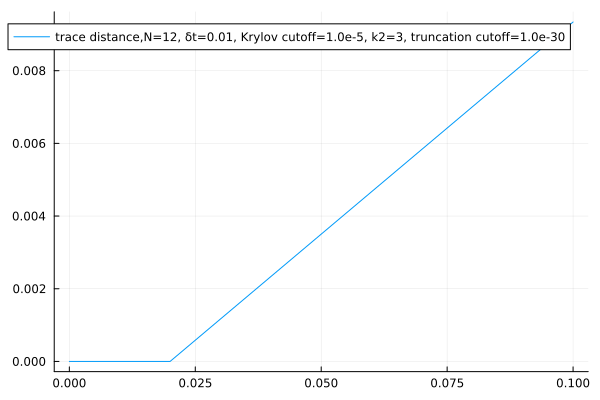

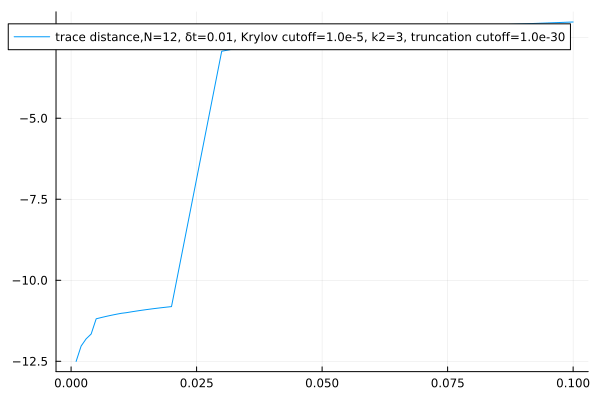

In [91]:

other_norms=false
save_bool = false
times1 = Vector(LinRange(δt1,T_enrich,Int(nframe_en1)))
times2 = Vector(LinRange(T_enrich+δt,T,Int(nframe_un)))
 
error_propagation2(corr,times1,times2,H_single,δt1,δt2,Ci,N,Krylov_cutoff,k2,tdvp_cutoff,other_norms,save_bool)


In [85]:
length(times2)

8

In [74]:
append!(times1,times2)

search: push push! pushfirst pushfirst! pushdisplay expanduser PlotUtils



```
push(is::Indices, i::Index)
```

Make a new Indices with the Index i inserted at the end.


In [61]:
Vector(LinRange(δt1,T_enrich,Int(nframe_en1)))

20-element Vector{Float64}:
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.009999999999999998
 0.011
 0.012
 0.013
 0.014
 0.015
 0.016
 0.017
 0.018000000000000002
 0.019
 0.02

In [59]:
length(times2)

8

In [62]:
length(times1)

29

In [ ]:
function reaction_mapping(J,L)
    """
    Is there a better way to define J other than discretization as we only use it to create other objects?
    """
    
    
    
    """
    Inputs: J is an array 
    L is an integer

    
    First, do the mapping L times on the spectral density to get L modes.
    Are all parameters specified at this point?
    If so, apply (id cross U) to the hamiltonian to get star geometry, then carry on from there.
    
    
    This function should return an array of the self energies of the new bath modes, and the same for the couplings.
    To calculate this, loop over L, in each iteration calculate the new mapped density based on the previous one, then 
    calculate the self energy and coupling. 
    
    Need a way to compute the hilbert transform.
    
    Both lambda^2 and the spectral densities are both defined with 2pi factors.
    """
    self_energies = zeros(L)
    couplings = zeros(L)
    
    ##Calculate self energy and coupling 
    for i =1:L
        J_hilb = imag.(hilbert(J))
        J_new= 4*λ*J
        denom = J_hilb.^2 + J.^2
        J_new = J_new/denom
        J=J_new
        
        """calcualte new \lambda and self energy and store them
        """
    return self_energies, couplings
    
    
    

In [9]:

"""

What to do next:

-We need to work out whether the relative magnitudes of the Krylov states matter, i.e. do we include the delta t?

-The norm of ρ_n is falling, I think these two errors are connected as they both breakdown at the same time.
-I think I should have error checks for various properties of all the objects, i.e. the norm of ρ_n etc.

-Once the projector is diagonalised, the spectra are either 0 or 1, but numerically they deviate from this by an order of
~1e-14. Is there a way of recovering Vp from the diagonal matrix after the values have been rounded?

-The stochastic enrichment method is much more efficient and seems quite straight forward to implement.

-In the paper, they only use k=3 (two Krylov states) to avoid the high bond dimensions of higher order Krylov states.

-Ask on the discourse page if 1TDVP is implemented as this could be another option.



"""
     

5-element Vector{Float64}:
  1.7013016167040798
 -1.3763819204711736
 -0.6498393924658126
 -1.3763819204711734
  1.70130161670408

In [ ]:
"""
Potential efficiency improvements:

-Always sweeping towards the centre will prevent Projectors having an unnecessarily large dimension.

-At the end of the enrichment, the enriched state is almost canonical apart from the first sight which carries this 
extra k factor. Does TDVP need an orthogonal centre at N? If not, we may be able to avoid orthogonalization?

-    In most cases, abs_maxdim will be very high. We don't want to use this. However, if 
    for the other option we use the sum of all the linkdimensions (for n-1) of the Krylov states, 
    It won't be in canonical form so many of the dimensions will actually correspond to the same dimension. 
    Again, this isn't a huge problem because it will still likely be much less than abs_maxdim. I'm not sure how 
    this can be prevented, so I will just use the sum.
    
- Question: Does the kth Krylov state always contain within it the dimensions of the lower order Krylov states?
 This would solve the problem stated just about and would be more efficient.


-For 1TDVP, they found that for k=5 the creation of the Krylov states and the enrichment step were subleading to the TDVP step, but this isn't
what I have at the moment. 2TDVP is slower than 1TDVP but more accurate, so we don't know if these steps should be subleading to TDVP or not, but 
there's definitely ways of increasing the efficiency of these steps.


-There's a more efficient but less accurate way to apply H to ψ, by using the variational approach that's used in TDVP itself. 


-In the paper, they say to use τ=δt but I'm not sure about this as for small delta t, these states won't be that different (think about this more).


-The bottleneck is creating the Krylov states, see if you can make the function more efficient (Vectorise?). 

-During the enrichment, there will be sites that are aleady max rank, i.e close to the first site. Instead of SvDing through
these sights manually, we could use orthogonalize to go between sites that can be enriched. I.e. say we have just enriched
site k, and the next site that can be enriched is site k-n. Instead of SvDing the n states between these two, we could use 
orthogonalize(ψ,k-n) to move to this sight.
"""